In [1]:
import os, sys, json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
# Paths (adjust if your layout differs)
ROOT = Path('/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit')
DATA = ROOT / "data"
SRC  = ROOT / "src"
SUBM = ROOT / "sample_submission"

# Ensure src is importable
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Create sample_submission dir if missing
SUBM.mkdir(parents=True, exist_ok=True)

SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
# Load dataset files
info_path = DATA / "dataset_info.json"
if info_path.exists():
    info = json.loads(info_path.read_text(encoding="utf-8"))
    print("dataset_info.json loaded. Keys:", list(info.keys()))
    print(json.dumps({k: info[k] for k in ['features','input_len','horizon_len','outputs']}, indent=2))
else:
    print("dataset_info.json not found at", info_path)

# Peek train / x_test
train_path = DATA / "train.pkl"
x_test_path  = DATA / "x_test.pkl"
y_local_path = DATA / "y_test_local.pkl"

train = pd.read_pickle(train_path)
x_test  = pd.read_pickle(x_test_path)
y_test_local = pd.read_pickle(y_local_path)

print("train shape:", train.shape, "| columns:", train.columns.tolist())
print("x_test  shape:", x_test.shape,  "| columns:", x_test.columns.tolist())
print("y_test_local shape:", y_test_local.shape, "| columns:", y_test_local.columns.tolist())

display(train.head(3))
display(x_test.head(3))
display(y_test_local.head(3))

dataset_info.json loaded. Keys: ['freq', 'features', 'input_len', 'horizon_len', 'dtypes', 'outputs', 'sha256']
{
  "features": [
    "close",
    "volume"
  ],
  "input_len": 60,
  "horizon_len": 10,
  "outputs": {
    "train": {
      "columns": [
        "series_id",
        "time_step",
        "close",
        "volume"
      ]
    },
    "x_test": {
      "columns": [
        "window_id",
        "time_step",
        "close",
        "volume"
      ]
    },
    "y_test_local": {
      "columns": [
        "window_id",
        "time_step",
        "close"
      ]
    }
  }
}
train shape: (18331224, 4) | columns: ['series_id', 'time_step', 'close', 'volume']
x_test  shape: (3000000, 4) | columns: ['window_id', 'time_step', 'close', 'volume']
y_test_local shape: (20, 3) | columns: ['window_id', 'time_step', 'close']


,series_id,time_step,close,volume
0,1,0,0.13700,171985.703125
1,1,1,0.13656,85451.398438
2,1,2,0.13647,121151.898438


,window_id,time_step,close,volume
0,1,0,0.1126,24976.0
1,1,1,0.1126,0.0
2,1,2,0.1125,2299.0


,window_id,time_step,close
0,1,0,0.1131
1,1,1,0.1131
2,1,2,0.1130


In [4]:
# Use the sampler logic from src/dataset.py to slice windows
from icaif.dataset import TrainWindowSampler

class WindowsDataset(Dataset):
    """
    Wrap TrainWindowSampler into a PyTorch Dataset.
    Returns:
      X: (60, 2) float32 -> [close, volume]
      y: (10,)  float32 -> future close
    """
    def __init__(self, train_path: str, rolling: bool = True, step_size: int = 1, max_samples: int = None):
        self.sampler = TrainWindowSampler(
            train_path=train_path,
            window=70,
            input_len=60,
            horizon_len=10,
            rolling=rolling,
            step_size=step_size,
            seed=SEED,
        )
        # Materialize (optionally capped) for stable batching
        xs, ys = [], []
        for i, (X, y) in enumerate(self.sampler.iter_windows()):
            xs.append(X.astype(np.float32))
            ys.append(y.astype(np.float32))
            if max_samples is not None and (i + 1) >= max_samples:
                break
        self.X = np.stack(xs, axis=0) if xs else np.zeros((0,60,2), dtype=np.float32)
        self.y = np.stack(ys, axis=0) if ys else np.zeros((0,10), dtype=np.float32)

    def __len__(self):  return len(self.X)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.from_numpy(self.y[i])

# For a quick demo, cap samples. Increase for better quality.
MAX_SAMPLES = None  # set to None to use all windows
train_ds = WindowsDataset(str(train_path), rolling=True, step_size=1, max_samples=MAX_SAMPLES)
len(train_ds), train_ds.X.shape, train_ds.y.shape

(18327774, (18327774, 60, 2), (18327774, 10))

In [5]:
from keras_sig import jax_gpu_signature, jax_gpu_logsignature

2025-10-24 08:34:59.858448: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 08:35:00.048674: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from keras_sig import jax_gpu_signature

n_total = train_ds.X.shape[0]
chunk_size = n_total // 100
sig_dim = jax_gpu_logsignature(train_ds.X[:1], depth=6, stream=False).shape[1]

all_sigs = []

for i, arr in enumerate(np.array_split(train_ds.X, 100)):

    # Assume arr has shape (..., 2)
    arr0 = arr[:, :, 0]
    arr1 = arr[:, :, 1]

    # Log diff only on the first feature
    log_arr0 = np.log(arr0)
    log_arr0 = np.nan_to_num(log_arr0, nan=0.0, posinf=0.0, neginf=0.0)

    diff0 = np.diff(log_arr0, axis=1, prepend=log_arr0[:, :1])
    diff0 = np.nan_to_num(diff0, nan=0.0, posinf=0.0, neginf=0.0)

    y_arr = (diff0*arr1).cumsum(axis=1)
    y_arr = y_arr[:,:,None]

    sig_np = jax_gpu_logsignature(y_arr, depth=6, stream=False)
    all_sigs.append(sig_np)
all_sigs = np.concatenate(all_sigs, axis=0)

In [23]:
jax_gpu_signature(y_arr, depth=8, stream=False)

Array([[-1.0517851e+02,  5.5312588e+03, -1.9392314e+05, ...,
         1.8804326e+09, -2.8244939e+10,  3.7185274e+11],
       [-6.2737877e+01,  1.9680220e+03, -4.1156352e+04, ...,
         8.4704352e+07, -7.5615213e+08,  6.0591386e+09],
       [-4.6392666e+01,  1.0761399e+03, -1.6641770e+04, ...,
         1.3854812e+07, -9.1532992e+07,  4.8473933e+08],
       ...,
       [-6.8093516e+03,  2.3183636e+07, -5.2621849e+10, ...,
         1.3845289e+20, -1.3468216e+23,  1.1463714e+26],
       [-6.8430249e+03,  2.3413496e+07, -5.3406380e+10, ...,
         1.4261206e+20, -1.3941399e+23,  1.1925163e+26],
       [-6.8243135e+03,  2.3285626e+07, -5.2969472e+10, ...,
         1.4028824e+20, -1.3676729e+23,  1.1666794e+26]], dtype=float32)

<Axes: >

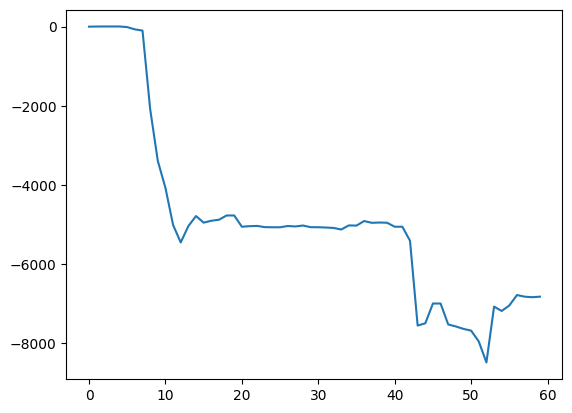

In [29]:
pd.Series(y_arr[-1].flatten()).plot()

In [41]:
jax_gpu_signature(y_arr, depth=4, stream=False).mean()

Array(1.067992e+26, dtype=float32)

In [38]:
sig_np[0]

Array([-1.9601583e-03,  2.0828039e+06, -2.5402197e+02,  1.6398919e+00,
       -1.4595407e+09,  5.8532180e-04, -1.1864950e+05, -5.7010054e+13,
        5.9605463e-07, -1.0436504e+03,  4.7523027e+03,  3.7145123e+11,
       -1.3335108e+11,  1.5799416e+20,  1.9396662e-10, -3.9099312e-01,
        2.1379566e+00,  3.8420480e+06,  1.7665434e+08, -4.5028557e+08,
        4.5827645e+16, -4.9867250e+16,  5.5334329e+24], dtype=float32)

In [7]:
import pickle
with open("/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/data/sigs.pkl", "wb") as f:
    pickle.dump(all_sigs, f)